In [1]:
import os
os.environ['CUPY_ACCELERATORS'] = 'cutensor'
import numpy as np
import cupy as cp
from scipy import fft
import zarr
from matplotlib import pyplot, colors, cm
from PIL import Image
from IPython.display import display
from tqdm.notebook import tqdm, trange

mempool = cp.get_default_memory_pool()
pinned_mempool = cp.get_default_pinned_memory_pool()

def bytesize_string(nbytes):
    unit =          ['B',  'KiB' ,  'MiB' ,  'GiB' ,  'TiB' ,  'PiB' ,  'EiB' ,  'ZiB' ,  'YiB' ]
    size = np.array([ 1 , 1/2**10, 1/2**20, 1/2**30, 1/2**40, 1/2**50, 1/2**60, 1/2**70, 1/2**80]) * nbytes
    order_of_magnitude = np.argmax(size < 1.0) - 1
    return '{} {}'.format(size[order_of_magnitude], unit[order_of_magnitude])

def array_stats(a):
    print('{} × {} = {} | min: {}, max: {}, avg: {}'.format(a.shape, a.dtype, bytesize_string(a.nbytes), np.amin(a), np.amax(a), np.average(a)))

def display_image(values, color_map=None):
    values = values if color_map is None else cm.get_cmap(color_map)(values)
    display(Image.fromarray((np.flip(np.swapaxes(values, 0, 1), axis=0) * 255.0).astype(np.uint8)))
    
def save_image(name, values, color_map=None):
    values = values if color_map is None else cm.get_cmap(color_map)(values)
    Image.fromarray((np.flip(np.swapaxes(values, 0, 1), axis=0) * 255.0).astype(np.uint8)).save('figures/{}.png'.format(name))

In [3]:
# Focus range
n_f = 100
zeta_F = np.linspace(0.0, 5.0, num=n_f)

ranges = [np.arange(00, 100, dtype=np.uint8),
          np.arange(20, 80, dtype=np.uint8),
          np.arange(40, 60, dtype=np.uint8),
          np.arange(00, 80, dtype=np.uint8),
          np.arange(20, 100, dtype=np.uint8)]

n_ranges = len(ranges)

In [4]:
n_res = 4

n_a = np.arange(1, n_res+1, dtype=np.uint32) * 12
n_b = np.arange(1, n_res+1, dtype=np.uint32) * 140

In [8]:
scenes = ['car', 'chess', 'dragon', 'sponza']
n_scenes = len(scenes)

avg_iter = np.zeros(4)

for scene in scenes:
    times_iterations = zarr.open('data/{}/times-iteration-continuous.zarr'.format(scene), mode='r')
    avg_iter += times_iterations[:, -1]/200

for index_res in range(n_res):
    print(avg_iter[index_res])

1.4776344001293182
42.29315948486328
364.1771926879883
1999.1112365722656


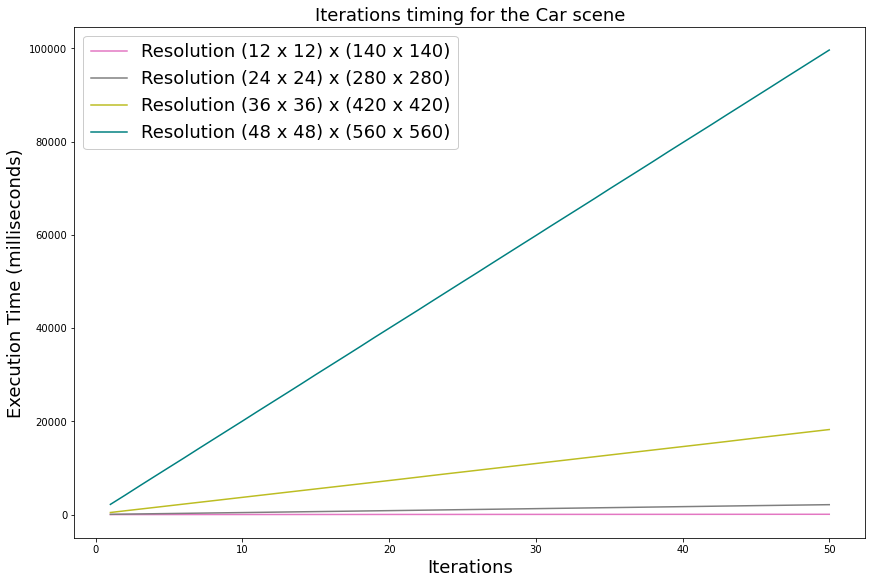

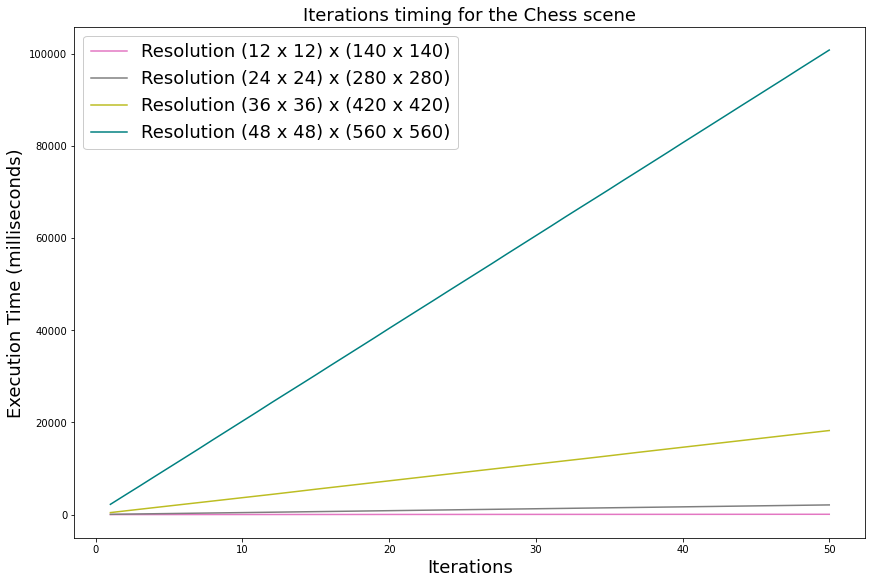

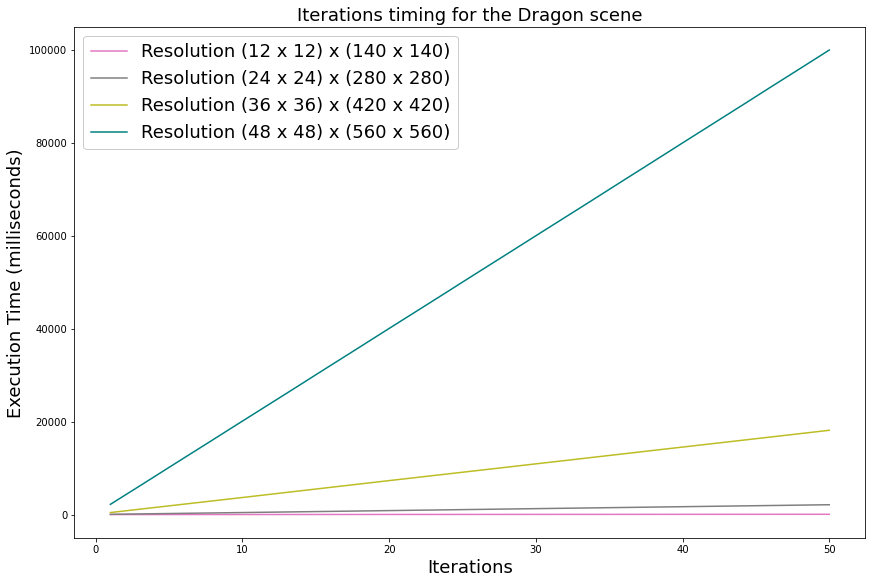

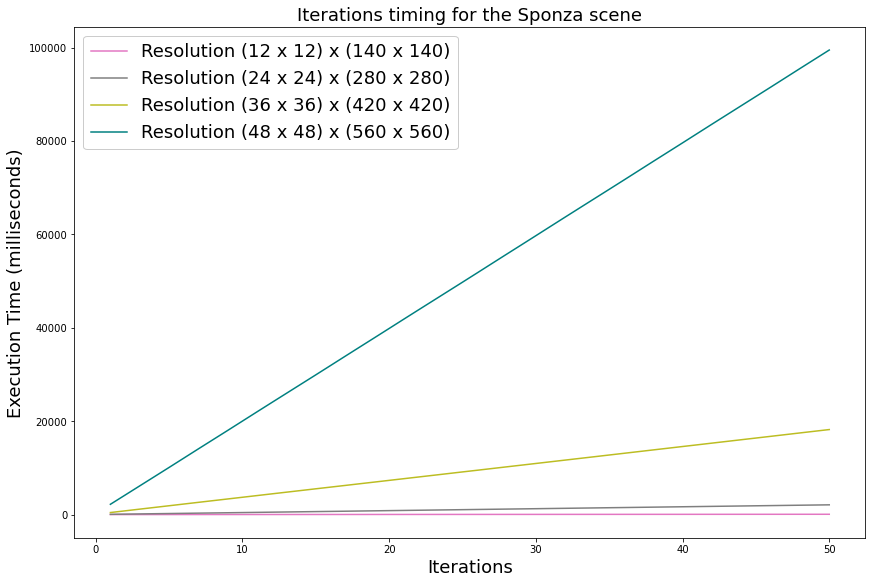

In [5]:
scenes = ['car', 'chess', 'dragon', 'sponza']
n_scenes = len(scenes)

iterations = np.arange(50) + 1

for scene in scenes:
    times_iterations = zarr.open('data/{}/times-iteration-continuous.zarr'.format(scene), mode='r')

    fig, ax = pyplot.subplots(constrained_layout=True, figsize=(12, 8))
    ax.set_title('Iterations timing for the {} scene'.format(scene.capitalize()), fontsize=18)
    ax.set_xlabel('Iterations', fontsize=18)
    ax.set_ylabel('Execution Time (milliseconds)', fontsize=18)

    res_color = ['C6', 'C7', 'C8', 'teal']
    for index_res in range(n_res):
        ax.plot(iterations, times_iterations[index_res], color=res_color[index_res], label='Resolution ({} x {}) x ({} x {})'.format(n_a[index_res], n_a[index_res], n_b[index_res], n_b[index_res]))

    ax.legend(fancybox=True, framealpha=1.0, fontsize=18)
    fig.savefig('figures/{}/{}-iterations-times.jpg'.format(scene, scene))

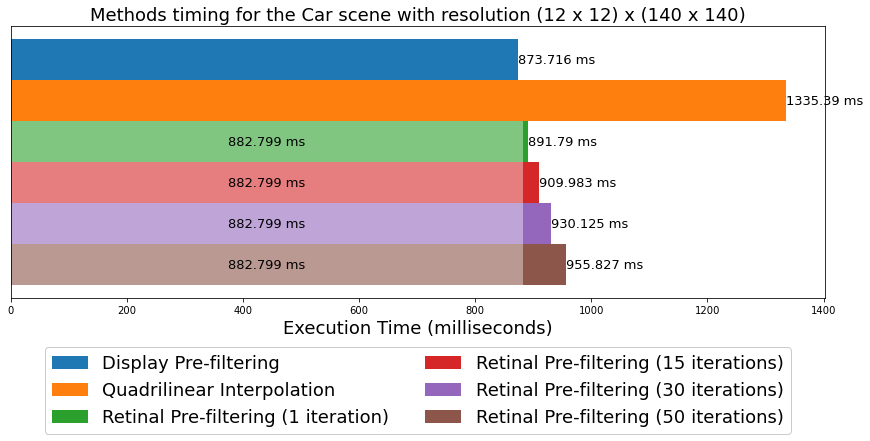

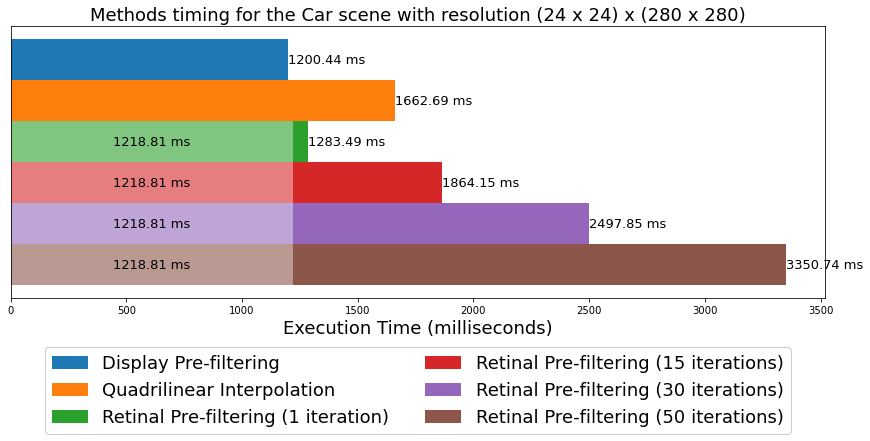

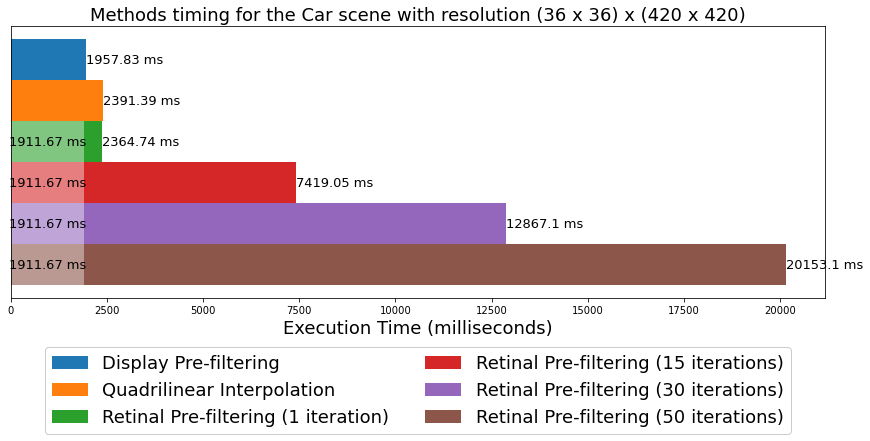

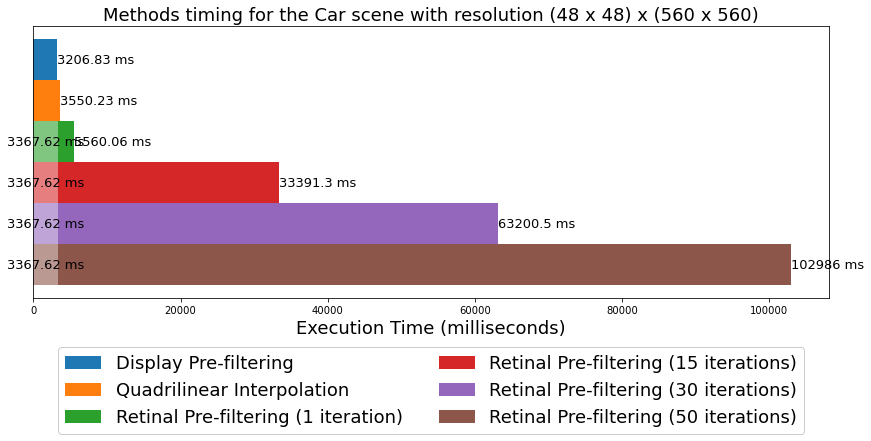

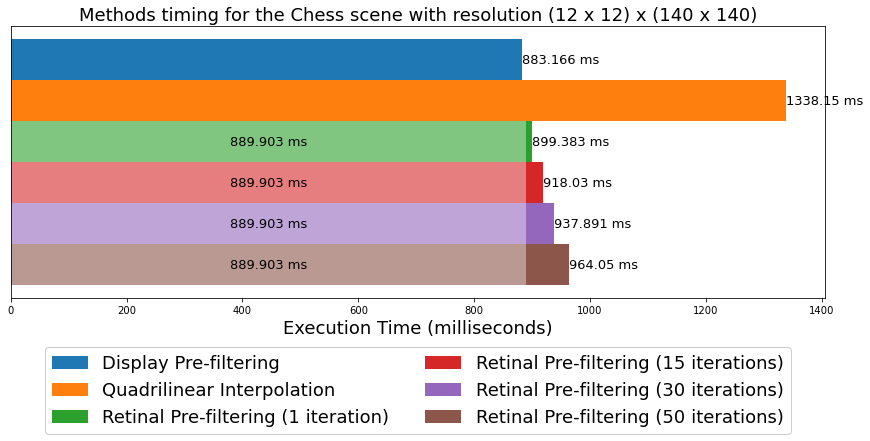

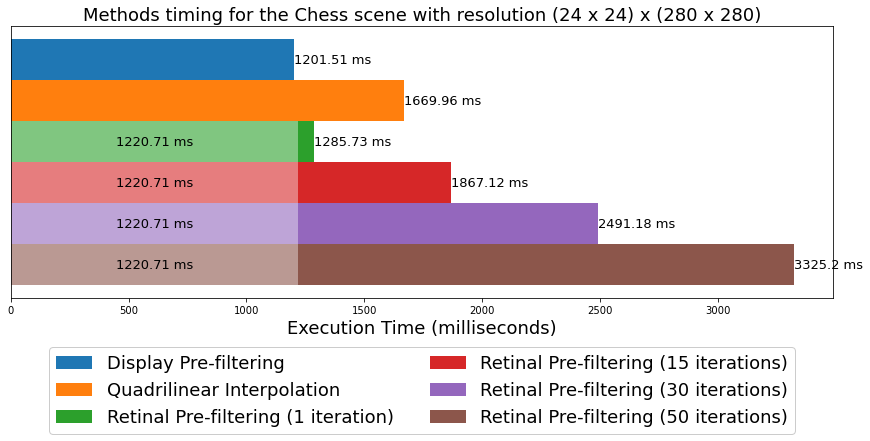

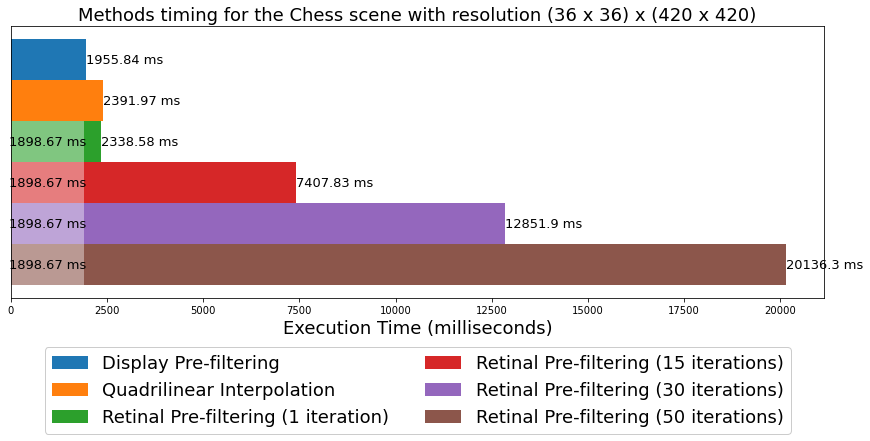

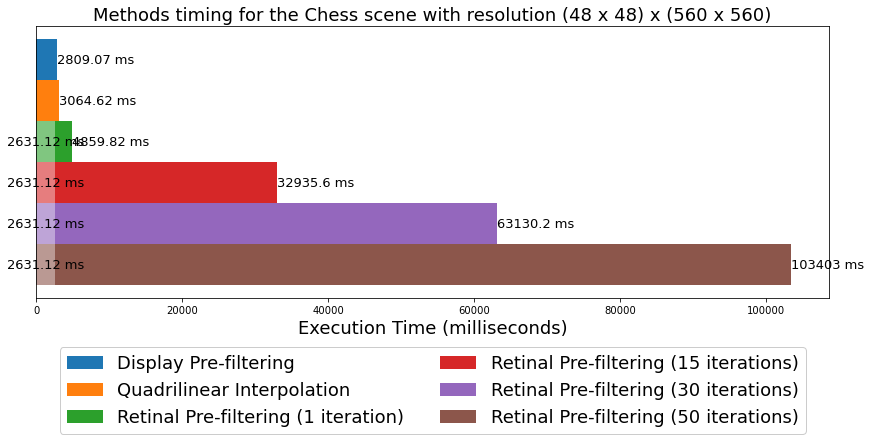

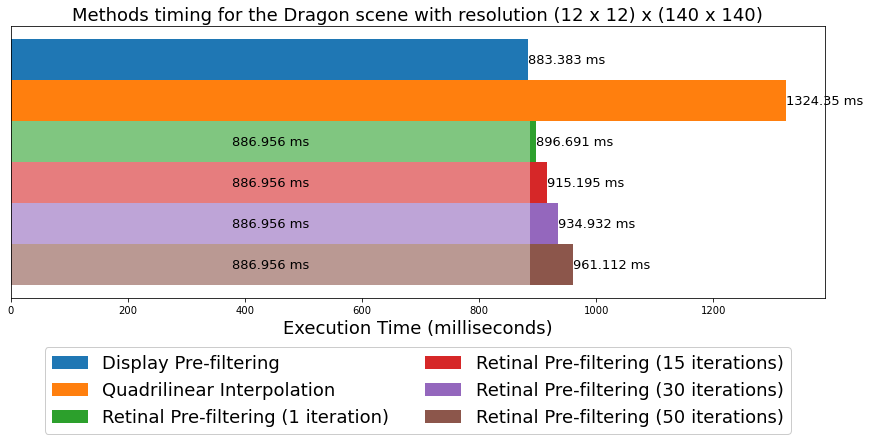

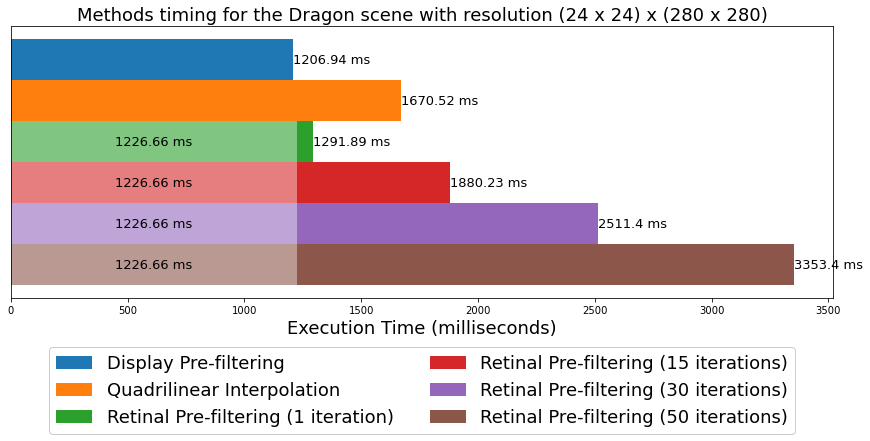

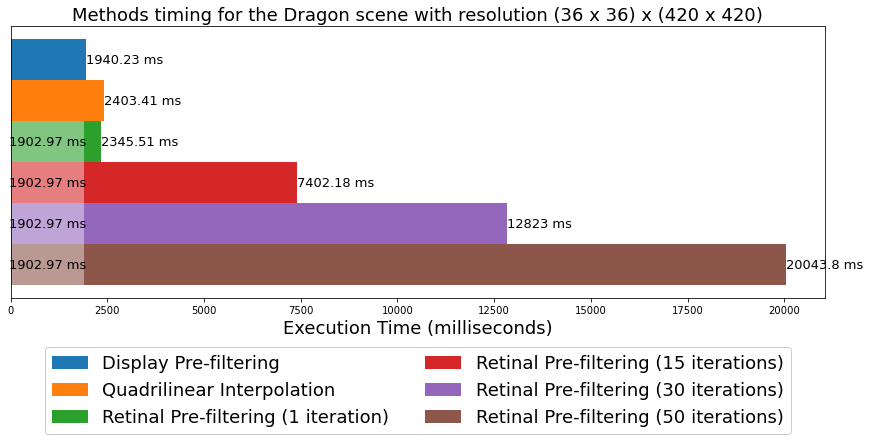

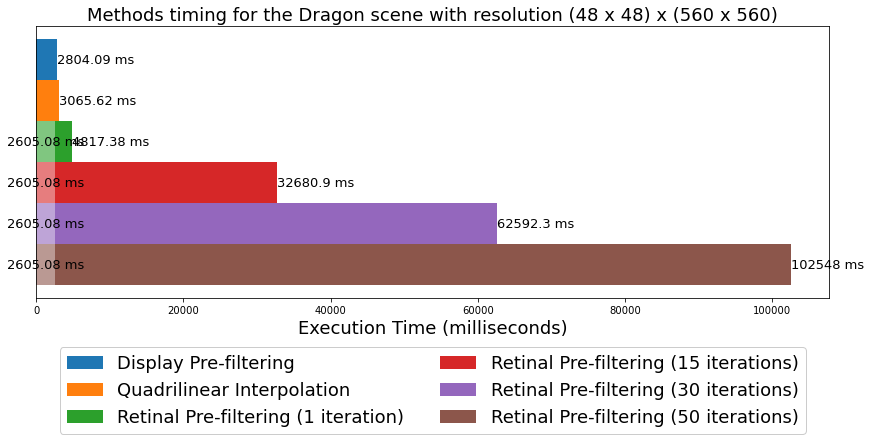

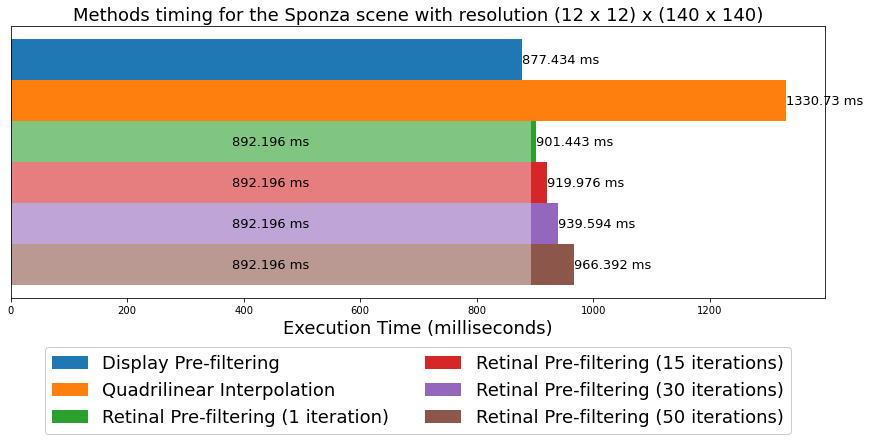

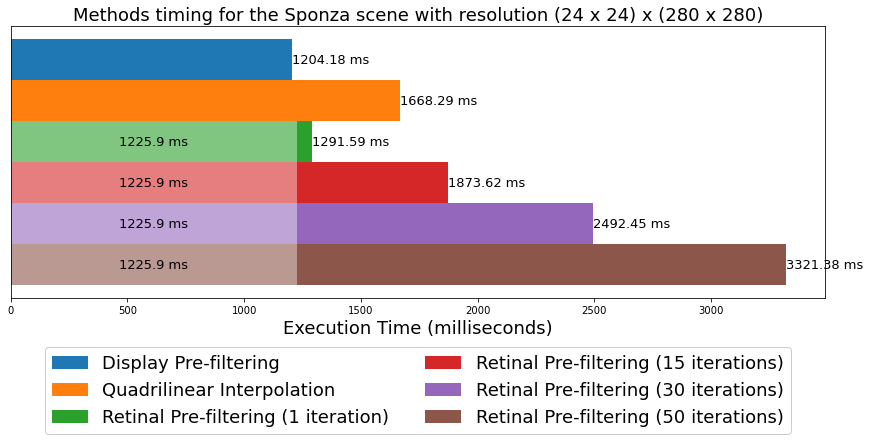

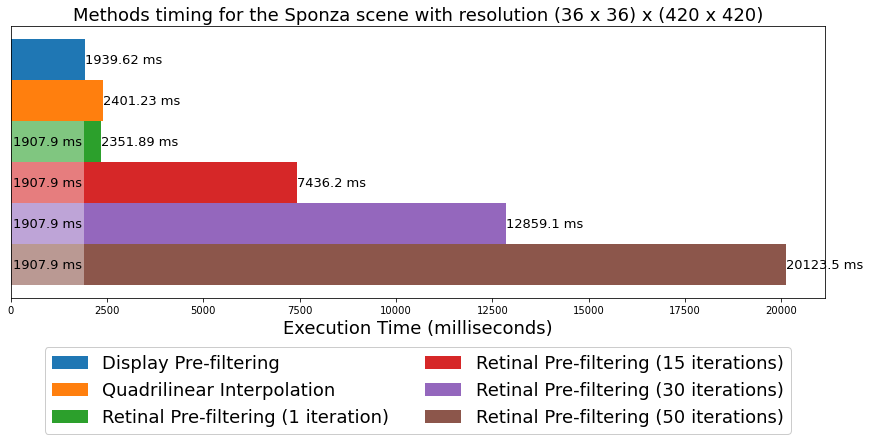

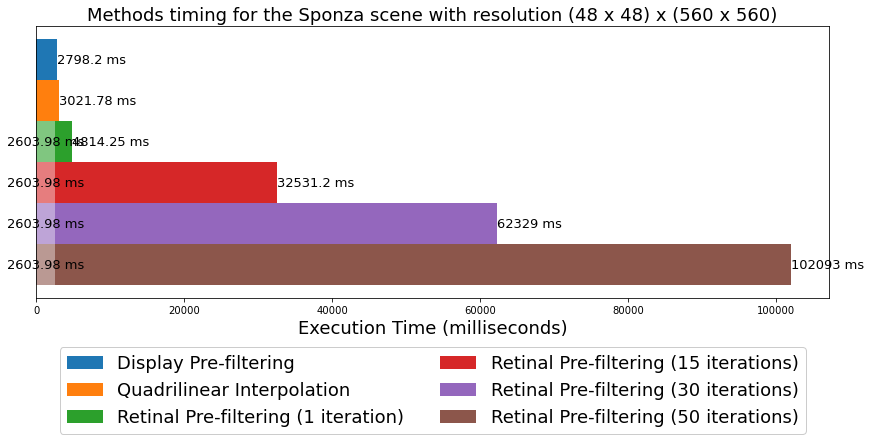

In [41]:
scenes = ['car', 'chess', 'dragon', 'sponza']
n_scenes = len(scenes)

iterations = np.arange(50) + 1

for scene in scenes:
    times_interpolation = zarr.open('data/{}/times-interpolation.zarr'.format(scene), mode='r')
    times_naive = zarr.open('data/{}/times-naive.zarr'.format(scene), mode='r')
    times_projection = zarr.open('data/{}/times-projection-continuous.zarr'.format(scene), mode='r')
    times_iterations = zarr.open('data/{}/times-iteration-continuous.zarr'.format(scene), mode='r')

    for index_res in range(n_res):
        fig, ax = pyplot.subplots(constrained_layout=True, figsize=(12, 6))
        ax.set_title('Methods timing for the {} scene with resolution ({} x {}) x ({} x {})'.format(scene.capitalize(), n_a[index_res], n_a[index_res], n_b[index_res], n_b[index_res]), fontsize=18)
        ax.set_xlabel('Execution Time (milliseconds)', fontsize=18)
        ax.set_yticks([])

        bar5 = ax.barh(5, times_naive[index_res], height=1.0, label='Display Pre-filtering', color='C0')
        bar4 = ax.barh(4, times_interpolation[index_res], height=1.0, label='Quadrilinear Interpolation', color='C1')
        bar3 = ax.barh(3, times_iterations[index_res, 0], left=times_projection[index_res], height=1.0, label='Retinal Pre-filtering (1 iteration)', color='C2')
        bar2 = ax.barh(2, times_iterations[index_res, 14], left=times_projection[index_res], height=1.0, label='Retinal Pre-filtering (15 iterations)', color='C3')
        bar1 = ax.barh(1, times_iterations[index_res, 29], left=times_projection[index_res], height=1.0, label='Retinal Pre-filtering (30 iterations)', color='C4')
        bar0 = ax.barh(0, times_iterations[index_res, 49], left=times_projection[index_res], height=1.0, label='Retinal Pre-filtering (50 iterations)', color='C5')

        bar3_ = ax.barh(3, times_projection[index_res], height=1.0, color='C2', alpha=0.6)
        bar2_ = ax.barh(2, times_projection[index_res], height=1.0, color='C3', alpha=0.6)
        bar1_ = ax.barh(1, times_projection[index_res], height=1.0, color='C4', alpha=0.6)
        bar0_ = ax.barh(0, times_projection[index_res], height=1.0, color='C5', alpha=0.6)

        ax.bar_label(bar5, label_type='edge', fontsize=13, fmt='%g ms')
        ax.bar_label(bar4, label_type='edge', fontsize=13, fmt='%g ms')
        ax.bar_label(bar3, label_type='edge', fontsize=13, fmt='%g ms')
        ax.bar_label(bar2, label_type='edge', fontsize=13, fmt='%g ms')
        ax.bar_label(bar1, label_type='edge', fontsize=13, fmt='%g ms')
        ax.bar_label(bar0, label_type='edge', fontsize=13, fmt='%g ms')

        ax.bar_label(bar3_, label_type='center', fontsize=13, fmt='%g ms')
        ax.bar_label(bar2_, label_type='center', fontsize=13, fmt='%g ms')
        ax.bar_label(bar1_, label_type='center', fontsize=13, fmt='%g ms')
        ax.bar_label(bar0_, label_type='center', fontsize=13, fmt='%g ms')

        ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, framealpha=1.0, fontsize=18, ncol=2)
        fig.savefig('figures/{}/{}-methods-times-{}x{}.jpg'.format(scene, scene, n_a[index_res], n_b[index_res]))

In [ ]:
scenes = ['car', 'chess', 'dragon', 'sponza']
n_scenes = len(scenes)

iterations = np.arange(50) + 1

for scene in scenes:
    mse_interpolation = zarr.open('data/{}/mse-interpolation.zarr'.format(scene), mode='r')
    mse_naive = zarr.open('data/{}/mse-naive.zarr'.format(scene), mode='r')
    mse_ranges = zarr.open('data/{}/mse-ranges.zarr'.format(scene), mode='r')
    mse_continuous = zarr.open('data/{}/mse-continuous.zarr'.format(scene), mode='r')
    mse_discrete = zarr.open('data/{}/mse-discrete.zarr'.format(scene), mode='r')

    fig, ax = pyplot.subplots(constrained_layout=True, figsize=(12, 8))
    ax.set_title('Convergence for the {} scene'.format(scene.capitalize()), fontsize=18)
    ax.set_xlabel('Iterations', fontsize=18)
    ax.set_ylabel('Mean Squared Error', fontsize=18)

    res_color = ['C6', 'C7', 'C8', 'teal']
    for index_res in range(n_res):
        ax.plot(iterations, np.average(mse_continuous[:, index_res], axis=-1), color=res_color[index_res], label='Resolution ({} x {}) x ({} x {})'.format(n_a[index_res], n_a[index_res], n_b[index_res], n_b[index_res]))

    ax.legend(fancybox=True, framealpha=1.0, fontsize=18)
    fig.savefig('figures/{}/{}-mse-convergence.jpg'.format(scene, scene))

    for index_res in range(n_res):
        fig, ax = pyplot.subplots(constrained_layout=True, figsize=(12, 8))
        ax.set_title('Methods MSE for the {} scene with resolution ({} x {}) x ({} x {})'.format(scene.capitalize(), n_a[index_res], n_a[index_res], n_b[index_res], n_b[index_res]), fontsize=18)
        ax.set_xlabel('Focus distance (in dioptres)', fontsize=18)
        ax.set_ylabel('Mean Squared Error', fontsize=18)

        ax.plot(zeta_F, mse_naive[index_res], label='Display Pre-filtering')
        ax.plot(zeta_F, mse_interpolation[index_res], label='Quadrilinear Interpolation')
        ax.plot(zeta_F, mse_continuous[-1, index_res], label='Retinal Pre-filtering (Unknown focus)')
        ax.plot(zeta_F, np.diag(mse_discrete[:, index_res]), label='Retinal Pre-filtering (Known focus)')

        ax.legend(fancybox=True, framealpha=1.0, fontsize=18)
        fig.savefig('figures/{}/{}-mse-methods-{}x{}.jpg'.format(scene, scene, n_a[index_res], n_b[index_res]))

        ylim = ax.get_ylim()



        fig, ax = pyplot.subplots(constrained_layout=True, figsize=(12, 8))
        ax.set_title('Ranges MSE for the {} scene with resolution ({} x {}) x ({} x {})'.format(scene.capitalize(), n_a[index_res], n_a[index_res], n_b[index_res], n_b[index_res]), fontsize=18)
        ax.set_xlabel('Focus distance (in dioptres)', fontsize=18)
        ax.set_ylabel('Mean Squared Error', fontsize=18)
        ax.set_ylim(ylim)

        ax.plot(zeta_F, mse_ranges[0, index_res], color='C2', label='Retinal Pre-filtering (Focus range 0 dpt ~ 5 dpt)')
        ax.plot(zeta_F, mse_ranges[1, index_res], color='C4', label='Retinal Pre-filtering (Focus range 1 dpt ~ 4 dpt)')
        ax.plot(zeta_F, mse_ranges[2, index_res], color='C5', label='Retinal Pre-filtering (Focus range 2 dpt ~ 3 dpt)')
        ax.plot(zeta_F, mse_discrete[50, index_res], color='C9', label='Retinal Pre-filtering (Focus at 2.5 dpt)')

        ax.legend(fancybox=True, framealpha=1.0, fontsize=18)
        fig.savefig('figures/{}/{}-mse-ranges-{}x{}.jpg'.format(scene, scene, n_a[index_res], n_b[index_res]))